## Data input and featurization  [➜ 📓](01-data-io-and-featurization.ipynb) 
### Loading data. 
Note: `pyemma` has glitches reading `.mdcrd` files; use `.nc` files instead.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import glob
import mdtraj
import pyemma
from pyemma.util.contexts import settings
import parmed as pmd
import pandas as pd

topfile = '/home/winter/onsager/amber/strip.Snolog1.prmtop'
trajs = sorted(glob.glob('/home/winter/onsager/amber/rev.Snolog*.nc'))
#trajs = sorted(glob.glob('/home/winter/onsager/amber/rev.Snolog10.nc'))
framestride = 1 # Downsample to speed up pyemma
timestep = 0.0008*framestride # time interval of the trajs in ns


# Get all dihedrals that have a FF term.
def parse_parmed_output(printDihedrals_string):
    df = pd.DataFrame()
    lines = printDihedrals_string.split("\n")
    for line in lines[1:-1]:
        if 'H' not in line:   # Exclude all dihedrals containing H.
            df = df.append(
                pd.DataFrame(
                    {
                        "atom1": int("".join(line[7:9]))-1,  # change from 1-index to 0-index
                        "atom2": int("".join(line[27:32]))-1,
                        "atom3": int("".join(line[49:52]))-1,
                        "atom4": int("".join(line[69:73]))-1,
                        },
                    index=[0],
                ),
                ignore_index=True,
            )
    return df


print("Trajs used:",trajs)
pmdoutput = pmd.tools.actions.printDihedrals(pmd.load_file(topfile))
df = parse_parmed_output(str(pmdoutput))
dihedrals = df.sort_values(['atom1','atom2','atom3','atom4']).to_numpy()



# Downsampling is possible by setting `stride`
dihedral_feat = pyemma.coordinates.featurizer(topfile)
dihedral_feat.add_dihedrals(dihedrals,cossin=True, periodic=True)
dihedral_data = pyemma.coordinates.load(trajs, features=dihedral_feat, stride=framestride)
labels = ['Dihedrals']

Trajs used: ['/home/winter/onsager/amber/rev.Snolog1.nc', '/home/winter/onsager/amber/rev.Snolog10.nc', '/home/winter/onsager/amber/rev.Snolog11.nc', '/home/winter/onsager/amber/rev.Snolog12.nc', '/home/winter/onsager/amber/rev.Snolog13.nc', '/home/winter/onsager/amber/rev.Snolog2.nc', '/home/winter/onsager/amber/rev.Snolog3.nc', '/home/winter/onsager/amber/rev.Snolog4.nc', '/home/winter/onsager/amber/rev.Snolog5.nc', '/home/winter/onsager/amber/rev.Snolog6.nc', '/home/winter/onsager/amber/rev.Snolog7.nc', '/home/winter/onsager/amber/rev.Snolog8.nc', '/home/winter/onsager/amber/rev.Snolog9.nc']


Show input data histograms:

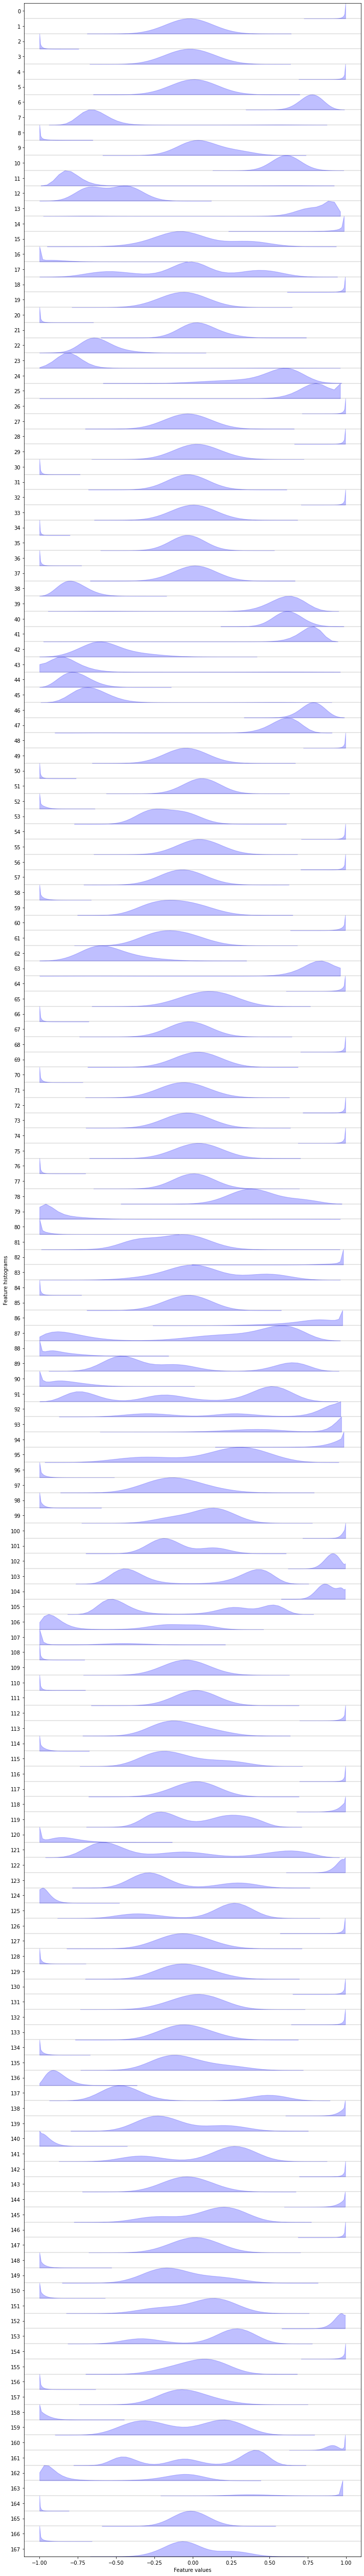

In [2]:
test_concatenated = np.concatenate(dihedral_data)
fig, ax = plt.subplots(figsize=(10, 70))
pyemma.plots.plot_feature_histograms(test_concatenated,ignore_dim_warning=True,ax=ax)
fig.tight_layout()

### VAMP2 scores for varying the dimension parameter for several lag times:
No. of dimensions can be chosen from the plot, but lag time can not be chosen from this.
This cell can take very long time to finish:
Downsample 1000 - 46s
Downsample 100 - 131s
Downsample 10 - 1440s
Maybe run VAMP2 score with 10 times downsample to determine no. of dimensions, then switch to no downsample and skip VAMP2 score

In [3]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.
    
    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.
    
    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores


KeyboardInterrupt: 

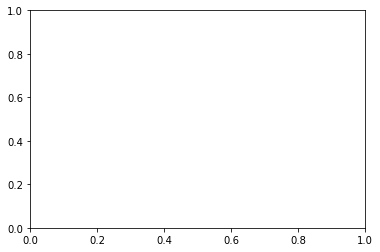

In [4]:
%%time

lags = [1,4,16,64]
dims = 3+np.arange(8)

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(dihedral_data, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.5f}ns'.format(lag * timestep))
    ax.grid(True)
ax.legend(loc='lower right')
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()

The above plot suggests 8 or 3 dimensions to be good choices, depending on the lag time

We try a TICA projection.
Please note that this is a modeler's choice based on the best heuristic that is currently available to our knowledge. 
It might be necessary to re-adjust the TICA lag time after the MSM estimation. 


## Coordinate transform and discretization

### TICA

The goal of the next step is to find a function that maps the usually high-dimensional input space into some lower-dimensional space that captures the important dynamics.
The recommended way of doing so is a time-lagged independent component analysis (TICA), <a id="ref-4" href="#cite-tica2">molgedey-94</a>, <a id="ref-5" href="#cite-tica">perez-hernandez-13</a>.
We perform TICA (with kinetic map scaling) using the lag time obtained from the VAMP-2 score.


In [5]:
lagsteps = 1

#tica = pyemma.coordinates.tica(dihedral_data, lag=lagsteps, weights="koopman")
tica = pyemma.coordinates.tica(dihedral_data, lag=lagsteps, weights="koopman", dim=8)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

# output (a, b) indicates tica projected to b dimensions. If b=1, you are in trouble, likely due to lag time too big.
print(tica_concatenated.shape) 

(8711100, 8)


⚠️ Please note that the above variable `tica_concatenated` is a concatenation of independent trajectories and as such **not suitable** for any kind of analysis which **evaluates transitions**.
We use this variable purely for visualization purposes which require concatenated data.
Throughout all notebooks, we will use the `_concatenated` postfix to denote data which is not safe to run a TICA or MSM estimation on.

We visualize the marginal and joint distributions of our TICA components by simple histograming:

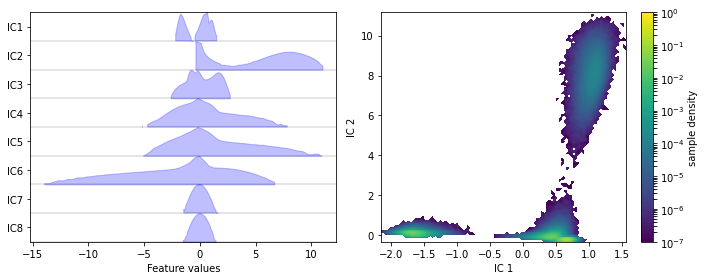

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=['IC1', 'IC2', 'IC3','IC4','IC5','IC6','IC7','IC8'],
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

Let’s have a look at one of the trajectories and what it looks like in the space of the first four TICA components.
We can see that the TICA components nicely resolve the slow transitions as discrete jumps.
Thus, metastability is well-described in this projection.

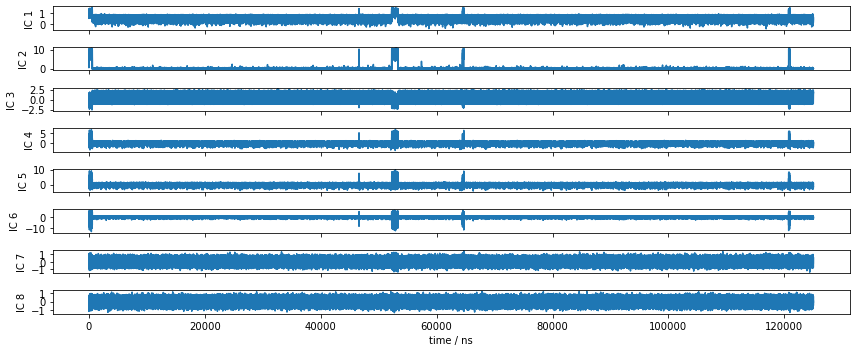

In [7]:
fig, axes = plt.subplots(8, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()

### Discretization

The TICA coordinates will now be clustered into a number of discrete states using the $k$-means algorithm.
The $k$-means algorithm requires as input the desired number of clusters.
The trajectories are automatically assigned to the cluster centers by calling `cluster.dtrajs`. 

⚠️ It is a priori unclear what the optimal number of cluster centers $k$ is.
It largely depends on the distribution of our data and on the number of dimensions we use.

In the following, we will estimate unvalidated Markov models using different numbers of cluster centers and use the VAMP-2 score (using cross validation) as a heuristic.
Since the clustering algorithm is stochastic,
we conduct 5 rounds of discretization at each number of cluster centers.

In [8]:
%%time
n_clustercenters = [4, 16, 64, 256]

scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(tica_output, k=k, max_iter=50, stride=100)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, lag=lagsteps, reversible=True, weights='oom')
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

KeyboardInterrupt: 

64 clusters seems to be best
My previous works suggest 3 metastable states to be chemically intuitive, but when I use 3 clusters, the included clusters are not the ones I want because one cluster that I want has really low probability. Also, the strategy in pyemma's tutorial notebook seems to involve multiple stages of data compression: from >100 dimensions to a few TICA dimensions, then from continuous TICA dimensions to discrete clusters, then from clusters to MSM states. So it's not needed to have as few clusters as the final no. of MSM states.

As already stated above, the score has been generated using MSMs that were not validated,
meaning that the above plot is really just a heuristic.
Besides having an optimal score, we want to obtain a model that describes physically interesting states.
Thus, the number of states $k$ is often re-adjusted after model inspection.

In [9]:
cluster = pyemma.coordinates.cluster_kmeans(tica_output, k=64, max_iter=500, stride=1)
#Using stride option might speed up pyemma.msm.its() in cell below

dtrajs_concatenated = np.concatenate(cluster.dtrajs)

We can check the location of our discrete states by plotting them onto the density of our data in the first two TICA dimensions.
The cluster centers are contained in the `cluster` object.

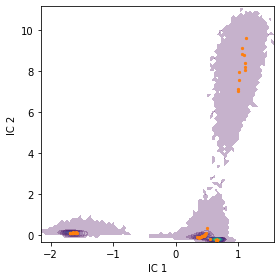

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

## MSM estimation and validation

### Implied timescales

The first validation that is usually done when estimating a Markov model is the estimation of implied timescales (ITS) $t_i$.
They are computed from the eigenvalues $\lambda_i$ of the Markov transition matrix by

$$ t_i = \frac{-\tau}{\ln\left|\lambda_i(\tau)\right|} $$ 

with $\tau$ being the lag time.
The ITS $t_i$ approximates the decorrelation time of the $i$-th process;
the latter being independent of the model's hyper-parameter $\tau$.
Thus, we look for ITS convergence and choose $\tau$ accordingly, i.e.,
within a range where the ITS are approximately invariant.
Please note that the lag time also represents the time resolution limit of the estimated Markov model <a id="ref-6" href="#cite-msm-jhp">prinz-11</a>, <a id="ref-7" href="#cite-swope-its">swope-04</a>.

Now, we calculate the ITS with `pyemma.msm.its()`,
The uncertainty of the implied timescales is quantified based upon Markov models sampled according to a Bayesian scheme.

⚠️ If this this is too time-consuming,
maximum likelihood MSMs can be used instead by setting the `errors` keyword argument to `None`.

Please note that, instead of a single number `lags=10`,
an array can be passed to compute the ITS at defined lag times.
When we pass an integer $K$ as this value,
a set of lag times starting from $\Delta t$ to $K\Delta t$ will be generated,
using a multiplier of $1.5$ between successive lag times.

CPU times: user 949 ms, sys: 2.31 s, total: 3.26 s
Wall time: 38.6 s


<AxesSubplot:xlabel='lag time / ns', ylabel='timescale / ns'>

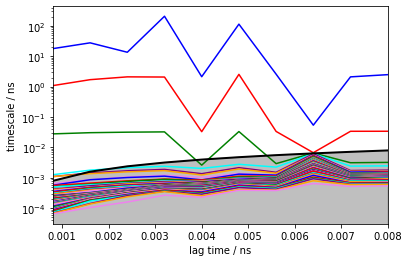

In [11]:
%%time
# This cell might be too time consuming if I change "errors" option to show error bar
its = pyemma.msm.its(cluster.dtrajs, lags=[1,2,3,4,5,6,7,8,9,10], errors='bayes',weights='oom')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=timestep);

The solid lines correspond to the ITS of maximum likelihood MSMs.
The confidence intervals are depicted by the shaded areas;
they contain 95% of the samples generated by the Bayesian MSM.
The sample means are given by dashed lines.

As a quick check, we print the fraction of states and counts that are in the active set. 

Please note the similarity of the `msm` object to the `tica` object.
Both are estimator instances and contain all the relevant information from the estimation and methods for validation and further analysis. 

In order to keep track of our trajectory time step, a `dt_traj` keyword argument can be passed that contains the trajectory time step unit.

In [12]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lagsteps, dt_traj='0.0008 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

/home/winter/anaconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/estimation/api.py:961: NotConvergedWarning: Reversible transition matrix estimation didn't converge.
  result = dense.mle.mle_trev.mle_trev(C, **kwargs)


fraction of states used = 1.00
fraction of counts used = 1.00


If the fractions are one then good. 

If it's lower than one, maybe there is a state that only has ins and no outs, or only outs and no ins? Many cells below will break unless this problem is addressed.

### Chapman-Kolmogorov test
The model is validated with a Chapman-Kolmogorov test. It compares the right and the left side of the Chapman-Kolmogorov equation

$$ \mathbf{P}(k \tau) = \mathbf{P}^k(\tau) $$

with $\mathbf{P}(\tau)$ being the transition matrix and lag time $\tau$.
PyEMMA automatically estimates a new MSM transition matrix at lag time $k \tau$ and propagates the original transition matrix by the $k$-th power.
The highest $k$ can be adjusted using the `mlags` keyword argument of `msm.cktest()`.

Since we can only inspect the result for a small number of (macro-) states,
we use the implied timescales plot as a heuristic to estimate a number of metastable states to test for. 
If we can resolve N slow processes then we will attempt to capture those processes choosing N+1 metastable states.

In [13]:
nstates = 4

In [14]:
%%time
# This cell might be too time consuming when not downsampling trajs

cktest = msm.cktest(nstates, mlags=5)
pyemma.plots.plot_cktest(cktest, units='ns');

Process ForkPoolWorker-12:
Process ForkPoolWorker-8:
Process ForkPoolWorker-11:
Process ForkPoolWorker-10:
Process ForkPoolWorker-10:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-9:
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-9:
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-7:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-10:
Process ForkPoolWorker-7:
Traceback (most recent call last):
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/winter/anaconda3/envs/pye

  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/home/winter/anaconda3/envs/pyemma/l

KeyboardInterrupt: 

KeyboardInterrupt
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/site-packages/multiprocess/queues.py", line 355, in get
    res = self._reader.recv_bytes()
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/site-packages/pyemma/_base/estimator.py", line 407, in estimate
    self._model = self._estimate(X)
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/site-packages/pyemma/msm/estimators/bayesian_msm.py", line 191, in _estimate
    _MLMSM._estimate(self, dtrajs)
  File "/home/winter/anaconda3/envs/pyemma/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return s

looks good.

## MSM spectral analysis [➜ 📓](04-msm-analysis.ipynb)

From the MSM object `msm`, various properties can be obtained. We start the spectral analysis by examining the implied timescales.

[1.70923646e+02 1.84151930e+00 2.80936923e-02]
[4.26128241e+01 1.85894420e-01 8.29568951e-05]


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (4).

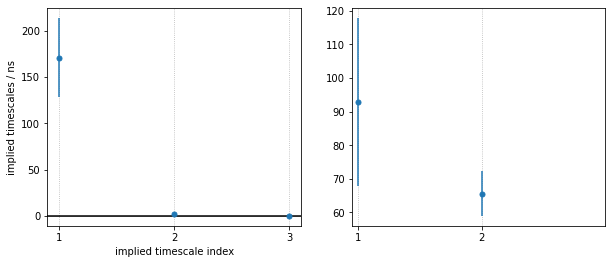

In [15]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 3

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

print(timescales_mean)
print(timescales_std)


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean, 
    yerr=timescales_std, 
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:], 
    yerr=its_separation_err(
        timescales_mean, 
        timescales_std), 
    fmt='.', 
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')
    
axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
#axes[0].set_ylim(0,2)
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()

As we see, PyEMMA sorts the implied timescales (and their corresponding eigenfunctions) in descending order.
From the timescale separation we can see that a comparably large timescale gap,
within the time resolution of the model, is between the 2th and 3th process,
suggesting that $3?$ metastable states may be a good choice for coarse graining.
We discuss this further below.

We go on by analyzing the stationary distribution and the free energy computed over the first two TICA coordinates.
The stationary distribution, $\pi$, is stored in `msm.pi` or (as an alias) `msm.stationary_distribution`.
We compute the free energy landscape by re-weighting the trajectory frames with stationary probabilities from the MSM (returned by `msm.trajectory_weights()`).

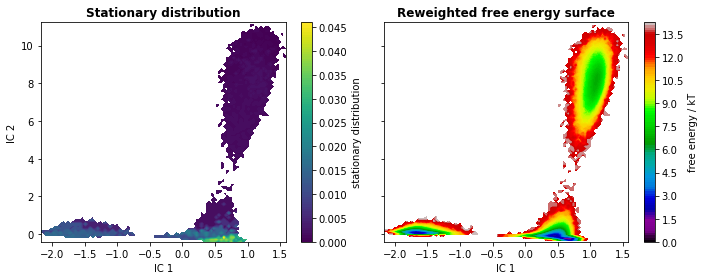

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

The eigenvectors corresponding to the slowest processes (largest implied timescales) contain information about what configurational changes are happening on which timescales.
We analyze the slowest processes by inspecting the value of the first four eigenfunctions projected on two the first TICA coordinates.
As the first right eigenvector corresponds to the stationary process (equilibrium), it is constant at $1$.

The first eigenvector is one: True (min=0.999999999952685, max=1.0000000000140716)
CPU times: user 5min 27s, sys: 1.48 s, total: 5min 28s
Wall time: 5min 27s


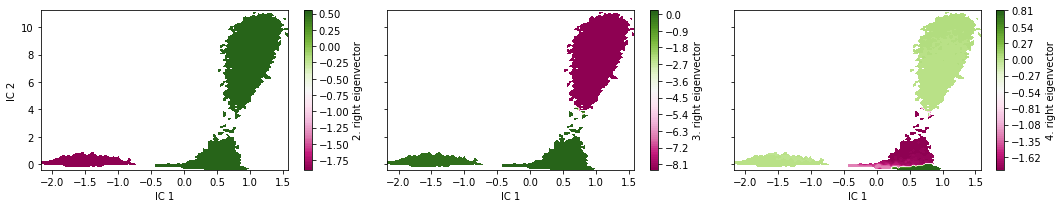

In [17]:
%%time
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, nits, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

The eigenvectors of the MSM contain information about the conformational changes are happening,
governed by the correponding implied timescales.
Specifically, the minimum and maximum-valued components of an eigenvector indicate the states between a process shifts probability.
The relaxation timescale of this exchange process is exactly the implied timescale.

Since the eigenvectors were internally sorted according to their eigenvalue,
the above visualizations depict the four slowest processes of the implied timescale plot.
We see that, indeed, the slowest processes occur inbetween the dense clusters in the TICA projection.

## PCCA & TPT [➜ 📓](05-pcca-tpt.ipynb)

### Perron cluster cluster analysis

**Note:** We will assign the integer numbers $1 \dots $ `nstates` to PCCA++ metastable states. As PyEMMA is written in Python, it internally indexes states starting from $0$. In consequence, numbers in the code cells differ by $-1$ from the plot labels and markdown text. 

In [18]:
msm.pcca(nstates)

PCCA(P=array([[0.0188 , 0.     , ..., 0.04305, 0.05209],
       [0.     , 0.10344, ..., 0.     , 0.     ],
       ...,
       [0.05364, 0.     , ..., 0.04144, 0.0587 ],
       [0.03158, 0.     , ..., 0.02856, 0.08864]]),
   m=4)

The PCCA++ algorithm computes so called memberships, i.e., the probability of each microstate to belong to a given macrostate.
In other words, PCCA++ does a fuzzy assignment of the microstates to macrostates which is encoded in the memberships.
We can visualize the membership distributions over the first TICA dimensions as follows:

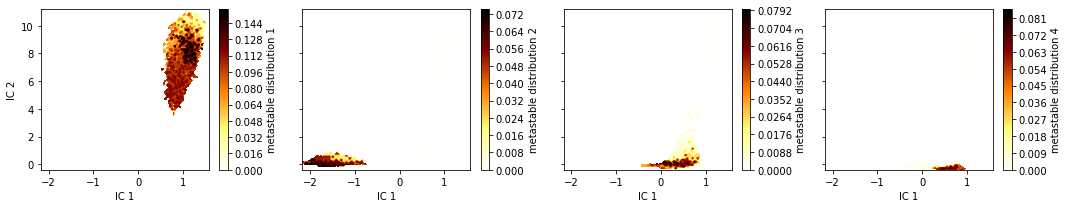

In [19]:
fig, axes = plt.subplots(1, nstates, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

In some cases, it might be useful to convert these distributions into crisp assignments.
This can be computed by taking the argmax of each microstate's memberships to the macrostates.
They are contained in `msm.metastable_assignments`. Let's see what this looks like in the first two TICA projections.

Substituting symbol S from STIXNonUnicode
Substituting symbol S from STIXNonUnicode
Substituting symbol S from STIXNonUnicode
Substituting symbol S from STIXNonUnicode
Substituting symbol S from STIXNonUnicode
Substituting symbol S from STIXNonUnicode
Substituting symbol S from STIXNonUnicode
Substituting symbol S from STIXNonUnicode


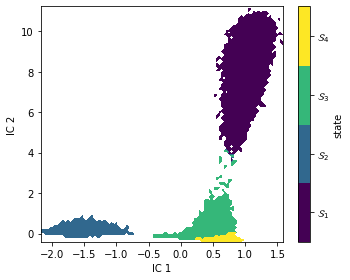

In [20]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()

State separation basically looks good, but still imperfect. The pyemma tutorial notebook also had this imperfection. Will this harm the accuracy of the transition rates, especially the smaller ones?

At this point, we usually want to investigate which molecular structures the identified metastable structures correspond to.
We generate a number of representative sample structures for each macrostate and store them in a trajectory file for visual inspection.
The following cell writes trajectory files to hard disc. They can be loaded and analyzed with external software packages.

In [21]:
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 10)
dihedral_source = pyemma.coordinates.source(trajs, features=dihedral_feat)
pyemma.coordinates.save_trajs(
    dihedral_source,
    pcca_samples,
    outfiles=['/home/winter/onsager/msm/pcca{}_10samples.pdb'.format(n + 1)
              for n in range(msm.n_metastable)])

['/home/winter/onsager/msm/pcca1_10samples.pdb',
 '/home/winter/onsager/msm/pcca2_10samples.pdb',
 '/home/winter/onsager/msm/pcca3_10samples.pdb',
 '/home/winter/onsager/msm/pcca4_10samples.pdb']

This coarse-grained representation of the dynamics is more directly amenable to human interpretation.
Nevertheless, as for the conventional MSM, we can still compute several interesting properties.
We start with the stationary distribution which encodes the free energy of the states.
This can be achieved by summing all the  contributions to a coarse-grained state $\mathcal{S}_i$:

$$ G_i = - \textrm{k}_\textrm{B} T \ln \sum_{j\in \mathcal{S}_i} \pi_j $$

In [22]:
print('state\tπ\t\tG/kT')
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))

state	π		G/kT
1	0.014143	4.258518
2	0.220410	1.512265
3	0.246418	1.400724
4	0.519028	0.655797


Knowing PCCA++ metastable states, we can also extract mean first passage times (MFPTs) between them:

In [23]:
from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3,4
1,0.00,732.20,1.86,2.09
2,336.34,0.00,206.52,206.73
3,130.29,730.79,0.00,0.08
4,130.39,730.89,0.08,0.00


As it will become clear in further sections, metastable state $1$ could be distinguished from the other states by experiment.
We can extract the MFPT into (out of) this state from (into) any other state using the Bayesian sample as follows:

In [24]:
A = msm.metastable_sets[0]
B = np.concatenate(msm.metastable_sets[1:])
print('MFPT 1 -> other: ({:6.1f} ± {:5.1f}) ns'.format(
    msm.sample_mean('mfpt', A, B), msm.sample_std('mfpt', A, B)))
print('MFPT other -> 1: ({:.1f} ± {:5.1f}) ns'.format(
    msm.sample_mean('mfpt', B, A), msm.sample_std('mfpt', B, A)))

MFPT 1 -> other: (   1.9 ±   0.2) ns
MFPT other -> 1: (179.6 ±  17.8) ns


The MFPT from state $1$ to any other state is very short compared to the other direction, i.e., this state has a comparably short lifetime. 

### Transition path theory

The flux between metastable states can be computed and coarse-grained as follows.
As an example, we compute the flux between metastable states $2$ and $4$.

Substituting symbol S from STIXNonUnicode
Substituting symbol S from STIXNonUnicode


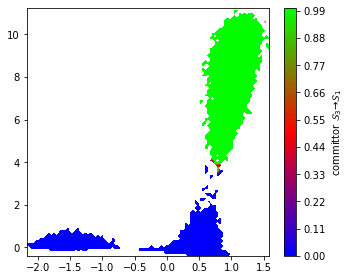

In [25]:
start, final = 3, 1
# convert to zero-indexing
start=start-1
final=final-1
A = msm.metastable_sets[start]
B = msm.metastable_sets[final]
flux = pyemma.msm.tpt(msm, A, B)

cg, cgflux = flux.coarse_grain(msm.metastable_sets)

fig, ax = plt.subplots(figsize=(5, 4))

pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    flux.committor[dtrajs_concatenated],
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'committor $\mathcal{S}_%d \to \mathcal{S}_%d$' % (
        start + 1, final + 1))
fig.tight_layout()

We find that the committor is constant within the metastable sets defined above.
Transition regions can be identified by committor values $\approx 0.5$.

In [26]:
# Calculate `coarse_state_centers` which is used to determine the position `pos` of each state in the plot
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]
#print(coarse_state_centers)

pyemma.plots.plot_network(inverse_mfpt,state_scale=1,state_labels=['1','2','3','4'],
                          arrow_label_format='%.2f ns',arrow_labels=mfpt,size=12,
                          #pos=0.01*coarse_state_centers
                         )

NameError: name 'inverse_mfpt' is not defined

# Some testing I added:

In [27]:
print(msm.count_matrix_active.shape)
print(msm.count_matrix_active)
print(msm.transition_matrix.shape)
print(msm.transition_matrix)

(64, 64)
[[ 3503.40203053     0.            92.69314049 ...     0.
   8038.38901172  9677.961228  ]
 [    0.         15462.20365102     0.         ...  7210.33861556
      0.             0.        ]
 [   84.24307748     0.         12916.94151522 ...     0.
    223.98747659    78.2965073 ]
 ...
 [    0.          7221.46190224     0.         ... 17380.78628568
      0.             0.        ]
 [ 7961.60918221     0.           242.70178545 ...     0.
   6161.65349177  8793.72958946]
 [ 9717.47875818     0.            77.55687539 ...     0.
   8694.32459444 27191.63937377]]
(64, 64)
[[0.01879508 0.         0.00047591 ... 0.         0.04304973 0.0520886 ]
 [0.         0.10344004 0.         ... 0.04833187 0.         0.        ]
 [0.00077905 0.         0.11405643 ... 0.         0.00206113 0.00068704]
 ...
 [0.         0.0473511  0.         ... 0.11419192 0.         0.        ]
 [0.05364294 0.         0.00156893 ... 0.         0.04144291 0.05870221]
 [0.03157638 0.         0.00025443 ... 0.   

The count_matrix and transition matrix are both on the level of cluster rather than level metastable state, and both have many elements being exactly zero. So these matrices retain the ability to differentiate between unobserved transition and low probability transition. PCCA++ losts the ability of differentiating because it does a fuzzy assignment of clusters to metastable states.

In the following cell I replace cluster time series by PCCA sharp assigment time series:

fraction of states used = 1.00
fraction of counts used = 1.00
[[1.255830e+05 0.000000e+00 5.400000e+01 0.000000e+00]
 [0.000000e+00 2.293018e+06 9.000000e+00 0.000000e+00]
 [5.000000e+01 7.000000e+00 1.980151e+06 4.579100e+04]
 [0.000000e+00 0.000000e+00 4.578400e+04 4.220640e+06]]
[[9.99570175e-01 0.00000000e+00 4.29824604e-04 0.00000000e+00]
 [0.00000000e+00 9.99996116e-01 3.88363199e-06 0.00000000e+00]
 [2.46782573e-05 3.50184144e-06 9.77370162e-01 2.26016579e-02]
 [0.00000000e+00 0.00000000e+00 1.07312499e-02 9.89268750e-01]]


/home/winter/anaconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/estimation/api.py:961: NotConvergedWarning: Reversible transition matrix estimation didn't converge.
  result = dense.mle.mle_trev.mle_trev(C, **kwargs)


(<Figure size 864x782.602 with 1 Axes>,
 array([[0.        , 0.        ],
        [1.        , 0.0746338 ],
        [0.47725907, 0.32722554],
        [0.43574345, 0.90578985]]))

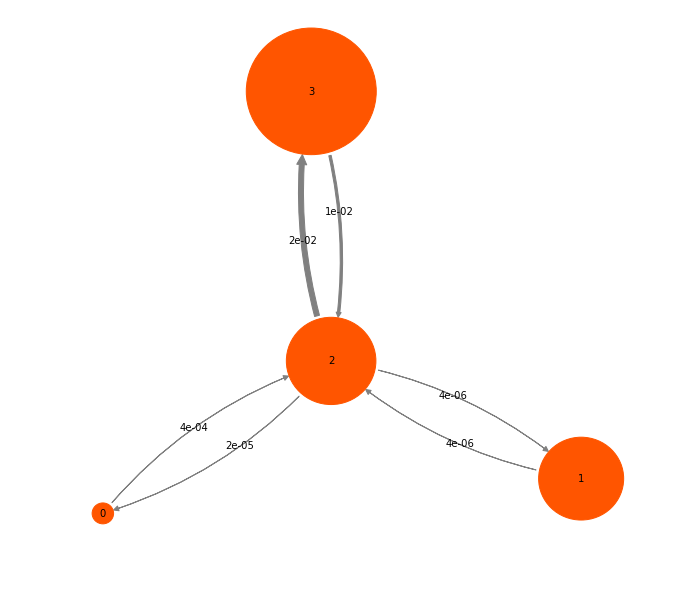

In [28]:
import copy
# def state_timeseries(series):
# #     x=x[643000:644000]
# #     y=y[643000:644000]
#     plt.rcParams['agg.path.chunksize'] = 10000
#     plt.figure(figsize=(100,5))
#     plt.xlabel('frame')
#     plt.ylabel('state')
#     plt.plot(series+1)
#     plt.show()  

metastable_traj=copy.deepcopy(cluster.dtrajs)
for i in range(13):
    #print("the i-th trajectory:",i+1)
    metastable_traj[i] = msm.metastable_assignments[cluster.dtrajs[i]]

teststeps = 1
#testmsm = pyemma.msm.bayesian_markov_model(metastable_traj, lag=teststeps, dt_traj='0.0008 ns')
testmsm = pyemma.msm.estimate_markov_model(metastable_traj, lag=teststeps, dt_traj='0.0008 ns')

print('fraction of states used = {:.2f}'.format(testmsm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(testmsm.active_count_fraction))

print(testmsm.count_matrix_active)
print(testmsm.transition_matrix)
pyemma.plots.plot_markov_model(testmsm,minflux=0)

The resulting MSM does have no transtions between certain state pairs when there is zero transition count between the pair. This holds even when `teststeps=100` and especially so when `teststeps=1`.

The following cells performs PCCA on the sharp MSM `testmsm`, print out the MFPT's, and plot the network with transition times (MFPT).

In [29]:
testmsm.pcca(nstates)
print(testmsm.metastable_sets)

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = testmsm.mfpt(
        testmsm.metastable_sets[i],
        testmsm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

[array([0]), array([1]), array([2]), array([3])]
MFPT / ns:


,1,2,3,4
1,0.00,724.58,1.86,1.93
2,335.92,0.00,205.99,206.06
3,129.92,722.72,0.00,0.07
4,130.00,722.80,0.07,0.00


In [30]:
pyemma.plots.plot_network(inverse_mfpt,state_scale=1,state_labels=['1','2','3','4'],
                          arrow_label_format='%.1f ns',arrow_labels=mfpt,size=12,
                          #pos=0.01*coarse_state_centers
                         )

NameError: name 'inverse_mfpt' is not defined

So the MFPT's are very close in `testmsm` compared to `msm`.

Also, note that even if two states are not directly connected, a finite MFPT still exists between the two states, so the MFPT network is always a fully connected network!

In summary, I found two kinds of network plot in pyemma, one plots the transition probability matrix and the other plots MFPT matrix. Transition probability matrix has the advantage of having zero terms for states that are not directly connected; the disadvantage is that pyemma doesn't seem to provide a function for calculating rate constants from the transition matrix, so I have to calculate it by hand as $\frac{1}{\text{rate constant}}=\frac{\text{lag time}}{\text{matrix element}}$ (reference: equation 20 of http://www.physicallensonthecell.org/discrete-state-kinetics-and-markov-models#equil_three). The following cell combines the two: use MFPT matrix to give out time numbers, and use transition probability matrix to delete arrows in MFPT plot that correspond to indirect transition.

(<Figure size 864x786.678 with 1 Axes>,
 array([[0.57367687, 0.        ],
        [1.        , 0.9105066 ],
        [0.5236071 , 0.57836829],
        [0.        , 0.82484071]]))

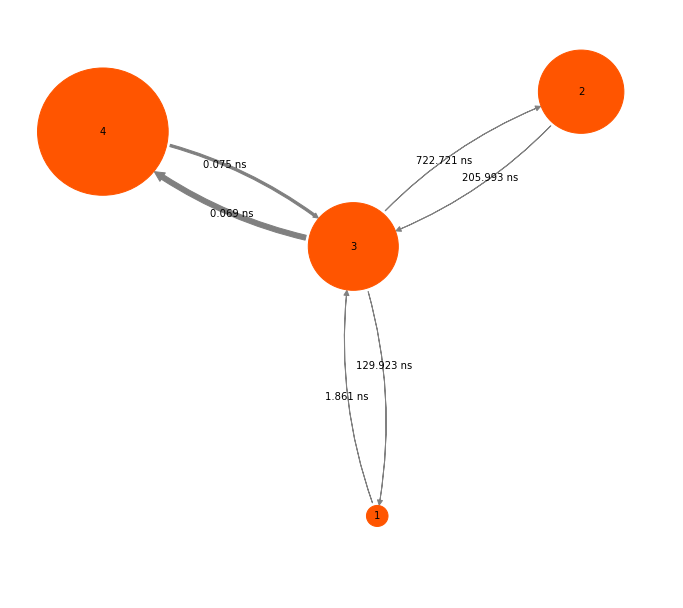

In [38]:
pyemma.plots.plot_markov_model(testmsm,minflux=0,state_labels=['1','2','3','4'],
                               arrow_label_format='%.3f ns',arrow_labels=mfpt,)

(<Figure size 1368.01x1440 with 1 Axes>,
 array([[0.7795297 , 1.        ],
        [0.95000563, 0.        ],
        [0.57727757, 0.45064472],
        [0.        , 0.35371885]]))

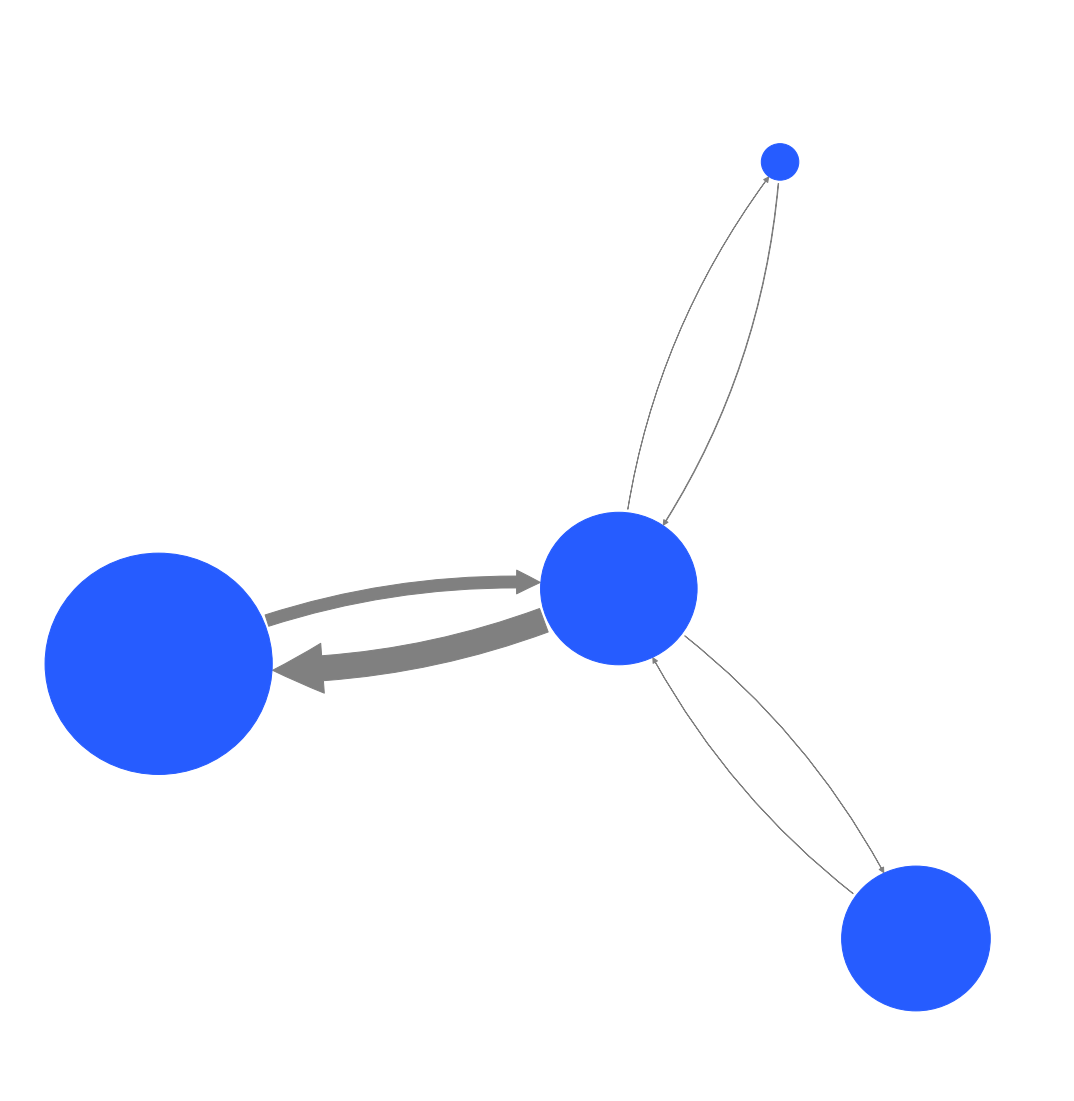

In [37]:
# Same as the cell above except changing some plot elements for easier figure tuning in Powerpoint.

pyemma.plots.plot_markov_model(testmsm,minflux=0,state_labels='    ',state_colors='#265cff',
                               arrow_label_format='%.1f ns',arrow_labels=None,arrow_scale=5.,
                               max_width=20, max_height=20)

# The following cell checks the beginning metastable state of each traj:

In [ ]:
metastable_traj=copy.deepcopy(cluster.dtrajs)
for i in range(13):
    #print("the i-th trajectory:",i+1)
    metastable_traj[i] = msm.metastable_assignments[cluster.dtrajs[i]]
    print(metastable_traj[i].shape)
    print(metastable_traj[i])